In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from pathlib import Path
from statsmodels.stats.multitest import multipletests

# Load data

In [37]:
data_folder = Path('../../../data')

In [38]:
sintef_fn = data_folder / 'this_project' / '1_e_coli_batch_cultures'/'1K_rates_and_values.csv'#'sintef_2023/sintef_2023_rates_1024.csv'

paczia_ecoli_fn = data_folder /'paczia_2012' / 'paczia_12_rates_ecoli.csv'
paczia_cglutamicum_fn =  data_folder /'paczia_2012' / 'paczia_12_rates_cglutamicum.csv'
paczia_yeast_fn =  data_folder /'paczia_2012' / 'paczia_12_rates_yeast.csv'
paczia_blicheniformis_fn = data_folder / 'paczia_2012' / 'paczia_12_rates_blicheniformis.csv'
vila_rates_fn = data_folder / 'vila_2023' / 'vila_2023_rates_and_values.csv'


In [39]:
sintef_df = pd.read_csv(sintef_fn, index_col=0)
paczia_df_ecoli = pd.read_csv(paczia_ecoli_fn, index_col = 0)
paczia_df_cglut = pd.read_csv(paczia_cglutamicum_fn, index_col = 0)
paczia_df_yeast = pd.read_csv(paczia_yeast_fn, index_col = 0)
paczia_df_blich = pd.read_csv(paczia_blicheniformis_fn, index_col = 0)
vila_df = pd.read_csv(vila_rates_fn, index_col=0)

In [40]:
df_rate = pd.concat([sintef_df, paczia_df_ecoli, paczia_df_cglut, paczia_df_blich,
          paczia_df_yeast, vila_df])
# df['Metabolite'] = df['Metabolite'].str.capitalize()

In [41]:
df_rate = df_rate[['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]',
       'Std. Err [mmol/gDW/h]', 'Metabolite value [gDW/mmol]', 'N carbons',
       'Mol weight [g/mol]', 'Turnover [mmol/gDW/h]', 'Species', 'Dataset']]

In [42]:
df_rate['Metabolite'] = df_rate['Metabolite'].replace({'L-serine': 'Serine', 
                                             # 'Propanoate': 'Propionate', 
                                             'Dihydroxyacetonephosphate': 'Dihydroxyacetone phosphate',
                                            'Deoxycarnitine (deoxy-c0)': 'Deoxycarnitine',
                                             'Glutarylcarnitine (c5-dc)': 'Glutarylcarnitine',
                                             'Sebacoyl-l-carnitine (c10-dc)': 'Sebacoyl-l-carnitine'})

df_rate.reset_index(inplace=True, drop=True)

## Any negative metabolite values?


In [43]:
(df_rate['Metabolite value [gDW/mmol]'] <0).sum()

np.int64(0)

In [10]:
mets = non_nan_mets = sorted(df_rate.Metabolite.unique())
non_nan_mets = sorted(df_rate.loc[~df_rate.isna().any(axis=1)].Metabolite.unique())


In [11]:
non_nan_mets

['2-phosphoglycerate',
 '3-phosphoglycerate',
 'Acetate',
 'Acetyl-ornithine',
 'Alanine',
 'Alpha-ketoglutarate',
 'Arginine',
 'Asparagine',
 'Aspartate',
 'Beta-alanine',
 'Beta-hydroxybutyrate',
 'Cis-aconitate',
 'Citrate',
 'Dihydroxyacetone phosphate',
 'Erythrose-4-phosphate',
 'Ethanol',
 'Formate',
 'Fructose-1,6-bisphosphate',
 'Fructose-6-phosphate',
 'Fumarate',
 'Gamma-aminobutyrate',
 'Glucose-6-phosphate',
 'Glutamate',
 'Glutamine',
 'Glyceraldehyde-3-phosphate',
 'Glycine',
 'Histidine',
 'Homoserine',
 'Isocitrate',
 'Isoleucine',
 'Lactate',
 'Leucine',
 'Lysine',
 'Malate',
 'Methionine',
 'NAD',
 'Orotate',
 'Oxaloacetate',
 'Phenylalanine',
 'Phosphoenolpyruvate',
 'Proline',
 'Propionate',
 'Putrescine',
 'Pyruvate',
 'Ribose-5-phosphate',
 'Ribulose-5-phosphate',
 'Sedoheptulose 7-phosphate',
 'Serine',
 'Shikimate',
 'Succinate',
 'Threonine',
 'Trans-aconitate',
 'Tryptophan',
 'Tyrosine',
 'Uracil',
 'Valine',
 'Xylulose-5-phosphate']

In [12]:
df_rate.notna().any(axis = 1)

0      True
1      True
2      True
3      True
4      True
       ... 
825    True
826    True
827    True
828    True
829    True
Length: 830, dtype: bool

# Load additional info

In [13]:
met_info_fn = data_folder / 'this_project' / '5_div' / '5C_metabolite_info.csv'

In [14]:
met_info = pd.read_csv(met_info_fn, index_col=0)

In [15]:
met_info.drop(columns=['Intracellular concentration [M]', 'Ref'], inplace=True)

In [16]:
df = df_rate.merge(met_info, left_on='Metabolite', right_on='Metabolite', how = 'outer')

In [17]:
# USe mol weight from pubchem
# df['Mol weight [g/mol]'] = df['Mass']
df.drop(columns=['Mass'], inplace=True)

# Get intracellular concentrations for E. coli

In [18]:
fn_i_conc = data_folder / 'this_project' / '4_paired_metabolomics_live_dead/4F_mapped_intracellular_conc.csv'
conditions_df = pd.read_csv(fn_i_conc, index_col=0)
conditions_df.dropna(inplace=True, subset=['Metabolite'])
conditions_df = conditions_df.loc[conditions_df['Phase'] == 'Exponential']



In [19]:
intracellular_metabolites = conditions_df.Metabolite.unique()

In [20]:
df.Species.unique()

array(['E. coli', 'C. glutamicum', 'B. licheniformis', 'S. cerevisiae',
       'Ecoli', 'Enterobacter', 'Pputida', 'Pseudomonas'], dtype=object)

In [21]:
for i, row in df.iterrows():
    if row['Species'] not in ['E. coli', 'Ecoli']:
        continue
    if row['Metabolite'] in intracellular_metabolites:
        cs = row['Carbon source'].capitalize()
        if cs == 'D-glucose':
            cs = 'Glucose'
        idx = (conditions_df.Metabolite == row['Metabolite'])&(conditions_df['Carbon source'] == cs)
        if np.sum(idx)>0:
            conc_uM = conditions_df.loc[idx, 'Intracellular concentration [uM]'].values[0]
        else:
            conc_uM = np.nan
        df.at[i, 'Intracellular concentration [uM]'] = conc_uM
        

    

## Calculate log-transformed values

In [22]:
df['log10(Rate [mmol/gDW/h])'] = np.log10(df['Rate [mmol/gDW/h]'])
df['log10(Metabolite value [gDW/mmol])'] = np.log10(df['Metabolite value [gDW/mmol]'])

/Users/snorre/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
df['Rate [mmol C/gDW/h]'] = df['Rate [mmol/gDW/h]']*df['N carbons']
df['Rate [g/gDW/h]'] = df['Rate [mmol/gDW/h]']*df['Mol weight [g/mol]']*1e-3

df['Metabolite value [gDW/mmol C]'] = df['Metabolite value [gDW/mmol]']/df['N carbons']
df['Metabolite value [gDW/g]'] = df['Metabolite value [gDW/mmol]']*1e3/df['Mol weight [g/mol]']


In [24]:
cols = ['Rate [mmol C/gDW/h]', 'Rate [g/gDW/h]', 'Metabolite value [gDW/mmol C]', 'Metabolite value [gDW/g]', 'Turnover [mmol/gDW/h]']
for col in cols:
    logcol = f'log10({col})'
    df[logcol] = np.log10(df[col])

/Users/snorre/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/snorre/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/snorre/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
df['Species - Carbon source'] = df['Species'] + ' - ' + df['Carbon source']

In [26]:
df['Intracellular concentration [M]'] = df['Intracellular concentration [uM]'] * 1e-6

## Save spreadsheet with rates to share

In [27]:
df.to_csv(data_folder / 'other'/ 'A_rates_and_values.csv')

In [28]:
rates_only_columns = ['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]',  'Species', 'Dataset',
       'Std. Err [mmol/gDW/h]','Rate [mmol C/gDW/h]','Rate [g/gDW/h]']
df.loc[df.Species=='E. coli', rates_only_columns].to_csv('ecoli_rates.csv')

In [29]:
df.columns

Index(['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]',
       'Std. Err [mmol/gDW/h]', 'Metabolite value [gDW/mmol]', 'N carbons',
       'Mol weight [g/mol]', 'Turnover [mmol/gDW/h]', 'Species', 'Dataset',
       'Metabolite id', 'Charge', 'Phosphate', 'Compound class', 'Comment',
       'Hydrogen Bond Donor Count', 'Hydrogen Bond Acceptor Count',
       'Rotatable Bond Count', 'Topological Polar Surface Area',
       'Charge (pubchem)', 'xlogP', 'pubchem id', 'Formula',
       'Molecular weight [g/mol]', 'ECMDB name', 'ECMDB ID',
       'Park et al. name', 'Thorfinnsdottir et al. abbrv',
       'Intracellular concentration [uM]', 'log10(Rate [mmol/gDW/h])',
       'log10(Metabolite value [gDW/mmol])', 'Rate [mmol C/gDW/h]',
       'Rate [g/gDW/h]', 'Metabolite value [gDW/mmol C]',
       'Metabolite value [gDW/g]', 'log10(Rate [mmol C/gDW/h])',
       'log10(Rate [g/gDW/h])', 'log10(Metabolite value [gDW/mmol C])',
       'log10(Metabolite value [gDW/g])', 'log10(Turnover [mmol/g

In [30]:
df.loc[df.Species=='E. coli']['Carbon source'].unique()

array(['Galactose', 'L-malate', 'L-alanine', 'Glucose'], dtype=object)

# Print out information about estimated rates

In [31]:
datasets = df.Dataset.unique()
for d in datasets:
    dfd = df.loc[df.Dataset==d]
    carbon_sources = dfd['Carbon source'].unique()
    for cs in carbon_sources:
        nanidx = dfd['Rate [mmol/gDW/h]'].notna()
        dfdcs = dfd.loc[(dfd['Carbon source'] == cs) & nanidx]
        for s in dfdcs.Species.unique():
            dfdcs_s = dfdcs.loc[dfdcs['Species'] == s]
            if len(dfdcs_s) > 0:
                print(f'{d} - {cs} - {s}: {len(dfdcs_s)}')
                print(dfdcs_s[['Metabolite', 'Rate [mmol/gDW/h]', 'Species', 'Carbon source', 'Dataset']])
                #
 


SINTEF-23 - Galactose - E. coli: 29
               Metabolite  Rate [mmol/gDW/h]  Species Carbon source    Dataset
42                Acetate           0.203725  E. coli     Galactose  SINTEF-23
108               Alanine          -0.000583  E. coli     Galactose  SINTEF-23
122    Alpha-aminoadipate           0.000028  E. coli     Galactose  SINTEF-23
154            Asparagine          -0.000128  E. coli     Galactose  SINTEF-23
168             Aspartate           0.000121  E. coli     Galactose  SINTEF-23
174          Beta-alanine           0.000028  E. coli     Galactose  SINTEF-23
222         Cis-aconitate           0.000102  E. coli     Galactose  SINTEF-23
263              Creatine           0.000001  E. coli     Galactose  SINTEF-23
272        Deoxycarnitine           0.000297  E. coli     Galactose  SINTEF-23
301               Formate           0.357255  E. coli     Galactose  SINTEF-23
344   Gamma-aminobutyrate           0.000009  E. coli     Galactose  SINTEF-23
357             

# Fraction of metabolite rates well described by a linear model of AUC
in Paczia

In [34]:
df_paczia = pd.concat([paczia_df_ecoli, paczia_df_cglut, paczia_df_blich,
          paczia_df_yeast])
df_meanp = df_paczia.groupby(['Metabolite abbrv.', 'Species']).mean(numeric_only=True).reset_index()
fraction_005 = (df_meanp['p-value']<0.05).sum()/df_meanp.shape[0]
print(f'Fraction of p-values < 0.05: {fraction_005:.2f}')
# df['Metabolite'] = df['Metabolite'].str.capitalize()
print(len(df_meanp), len(df_paczia))
# df_meanp.tail(20)
df_meanp['adj. p-value'] = multipletests(df_meanp['p-value'], method='fdr_bh')[1]

fraction_adj_005 = (df_meanp['adj. p-value']<0.05).sum()/df_meanp.shape[0]

print(f'Fraction of adjusted p-values < 0.05: {fraction_adj_005:.2f}')


Fraction of p-values < 0.05: 0.82
119 127
Fraction of adjusted p-values < 0.05: 0.79


In [35]:
df_paczia.loc[df_paczia['Species'] == 'S. cerevisiae']

,Metabolite abbrv.,Model ID,Metabolite,Metabolite value [gDW/mmol],MV min,MV max,Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],R2,p-value,Species,Carbon source,Dataset
0,ACT,s_0362,Acetate,0.000119,0.000119,0.000751,3.513848,2,59.044020,0.285047,0.037636,0.950300,0.004775,S. cerevisiae,Glucose,Paczia-13
1,ALA,s_0955,Alanine,0.003660,0.003385,0.003664,0.203462,3,89.093180,0.000156,0.000148,0.217694,0.350920,S. cerevisiae,Glucose,Paczia-13
2,AKG,s_0180,Alpha-ketoglutarate,0.009296,0.008661,0.009296,2.295749,5,144.082260,0.001967,0.000755,0.629342,0.059666,S. cerevisiae,Glucose,Paczia-13
3,ARG,s_0965,Arginine,0.104217,0.101482,0.104217,0.071265,6,175.208900,-0.000881,0.002919,0.043556,0.791299,S. cerevisiae,Glucose,Paczia-13
4,ASN,s_0969,Asparagine,0.056095,0.054956,0.056097,0.045101,4,132.117920,0.000064,0.000014,0.842417,0.009850,S. cerevisiae,Glucose,Paczia-13
5,ASP,s_0973,Aspartate,0.009769,0.009767,0.009863,0.564109,4,132.094740,0.000011,0.000004,0.715731,0.033744,S. cerevisiae,Glucose,Paczia-13
6,CIT,s_0522,Citrate,0.010610,0.009875,0.010610,0.119386,6,189.099700,0.000610,0.000149,0.943716,0.152487,S. cerevisiae,Glucose,Paczia-13
7,DHAP,s_0629,Dihydroxyacetonephosphate,0.006537,0.006537,0.008743,7.464696,3,168.041961,0.000031,0.000003,0.963961,0.000493,S. cerevisiae,Glucose,Paczia-13
8,ETH,s_0680,Ethanol,0.000587,0.000585,0.001046,4.220738,2,46.068440,8.002930,0.340528,0.992810,0.000019,S. cerevisiae,Glucose,Paczia-13
9,FBP,s_0555,"Fructose-1,6-bisphosphate",0.012645,0.012645,0.017089,0.000000,6,340.115682,0.000467,0.000158,0.686071,0.041693,S. cerevisiae,Glucose,Paczia-13


In [180]:
df_paczia.head()

,Metabolite abbrv.,Model ID,Metabolite,Metabolite value [gDW/mmol],MV min,MV max,Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],R2,p-value,Species,Carbon source,Dataset
0,23PG,2pg,2-phosphoglycerate,0.023198,0.016527,0.037230,12.219118,3,183.033421,0.000323,0.000015,0.990963,1.830542e-09,E. coli,Glucose,Paczia-13
1,23PG,3pg,3-phosphoglycerate,0.023130,0.016431,0.037207,12.219118,3,183.033421,0.000323,0.000015,0.990963,1.830542e-09,E. coli,Glucose,Paczia-13
2,ACT,ac,Acetate,0.009873,0.004352,0.021500,0.364498,2,59.044020,1.544754,0.188019,0.918369,1.754611e-04,E. coli,Glucose,Paczia-13
3,ALA,ala__L,Alanine,0.023765,0.016822,0.038971,0.629622,3,89.093180,0.000100,0.000012,0.913987,5.623168e-05,E. coli,Glucose,Paczia-13
4,AKG,akg,Alpha-ketoglutarate,0.036263,0.026843,0.056432,10.666347,5,144.082260,0.004123,0.001455,0.889260,2.159708e-01,E. coli,Glucose,Paczia-13


In [181]:
df.loc[df.Dataset=='Paczia-13'].head()


,Metabolite,Carbon source,Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],Metabolite value [gDW/mmol],N carbons,Mol weight [g/mol],Turnover [mmol/gDW/h],Species,Dataset,...,Metabolite value [gDW/g],log10(Rate [mmol C/gDW/h]),log10(Rate [g/gDW/h]),log10(Metabolite value [gDW/mmol C]),log10(Metabolite value [gDW/g]),log10(Turnover [mmol/gDW/h]),Species - Carbon source,Intracellular concentration [M],Growth impact,log10(Intracell. conc. [mM])
46,Acetate,Glucose,2.003534,0.145760,0.022533,2.0,59.04402,2.981847,B. licheniformis,Paczia-13,...,0.381637,0.602827,-0.927027,-1.948204,-0.418350,0.474485,B. licheniformis - Glucose,NaN,0.045146,NaN
477,Lysine,Glucose,0.231431,0.004825,0.111375,6.0,147.19550,0.057777,C. glutamicum,Paczia-13,...,0.756649,0.142573,-1.467684,-1.731362,-0.121106,-1.238244,C. glutamicum - Glucose,NaN,0.025776,NaN
45,Acetate,Glucose,1.544754,0.188019,0.009873,2.0,59.04402,0.364498,E. coli,Paczia-13,...,0.167221,0.489889,-1.039965,-2.306563,-0.776709,-0.438305,E. coli - Glucose,0.000658,0.015252,-0.181774
644,Pyruvate,Glucose,0.584596,0.028017,0.017532,3.0,87.05412,9.205248,E. coli,Paczia-13,...,0.201397,0.243977,-1.293355,-2.233279,-0.695947,0.964035,E. coli - Glucose,0.008050,0.010249,0.905796
297,Ethanol,Glucose,8.002930,0.340528,0.000587,2.0,46.06844,4.220738,S. cerevisiae,Paczia-13,...,0.012739,1.204279,-0.433347,-3.532482,-1.894856,0.625388,S. cerevisiae - Glucose,NaN,0.004697,NaN


# Plot!

In [182]:
df['Growth impact'] = df['Metabolite value [gDW/mmol]']*df['Rate [mmol/gDW/h]']

In [183]:
df.sort_values(by = 'Growth impact', ascending = False, inplace = True)

In [184]:
datasets = df.Dataset.unique()
for d in datasets:
    for cs in df['Carbon source'].unique():
        for s in df['Species'].unique():
            dfd = df.loc[(df['Dataset'] == d) & (df['Carbon source'] == cs) & (df['Species'] == s)]
            if len(dfd) > 0:
                total_impact = dfd.loc[dfd['Rate [mmol/gDW/h]'] > 0, 'Growth impact'].sum()
                print(d, cs, s, total_impact)    #
                # print(dfd.loc[dfd['Rate [mmol/gDW/h]'] > 0, ['Metabolite', 'Rate [mmol/gDW/h]', 'Metabolite value [gDW/mmol]',
                                                            #  'Growth impact', 
                                                            #   'Species', 'Carbon source', 'Dataset']])

Vila-23 D-Glucose Enterobacter 0.44143830130730355
Vila-23 D-Glucose Ecoli 0.27280242115812503
Vila-23 D-Glucose Pputida 0.009911929142676773
Vila-23 D-Glucose Pseudomonas 0.002836304021525186
Vila-23 D-Fructose Enterobacter 0.3105259112167256
Vila-23 D-Fructose Ecoli 0.21667235117738273
Vila-23 D-Fructose Pputida 0.020201495271010315
Vila-23 D-Fructose Pseudomonas 0.002750209869471835
Vila-23 Pyruvate Enterobacter 0.11016331513305891
Vila-23 Pyruvate Ecoli 0.16772375481631976
Vila-23 Pyruvate Pputida 0.0011278041661895784
Vila-23 Pyruvate Pseudomonas 0.0010495917622033778
Vila-23 L-Arabinose Ecoli 0.13718961547026692
Vila-23 D-Galactose Ecoli 0.1306817489130871
Vila-23 L-Malate Enterobacter 0.12061596899518837
Vila-23 L-Malate Ecoli 0.0845926847972802
Vila-23 L-Malate Pputida 0.004726970523522545
Vila-23 L-Malate Pseudomonas 0.006972647298295601
Vila-23 D-Ribose Ecoli 0.06907241716402196
Vila-23 Glycerol Enterobacter 0.02572412645482242
Vila-23 Glycerol Ecoli 0.06196131012623569
Vila-

In [185]:
df[['Metabolite', 'Rate [mmol/gDW/h]', 'Species', 'Carbon source', 'Dataset', 'Growth impact', 'Metabolite value [gDW/mmol]']].head(20)

,Metabolite,Rate [mmol/gDW/h],Species,Carbon source,Dataset,Growth impact,Metabolite value [gDW/mmol]
465,Lactate,5.517408,Enterobacter,D-Glucose,Vila-23,0.256820,0.046547
50,Acetate,5.995643,Ecoli,D-Fructose,Vila-23,0.167858,0.027997
58,Acetate,6.958493,Enterobacter,D-Fructose,Vila-23,0.146201,0.021010
56,Acetate,5.141351,Enterobacter,D-Glucose,Vila-23,0.143158,0.027844
55,Acetate,5.023546,Ecoli,Pyruvate,Vila-23,0.137787,0.027428
48,Acetate,4.708404,Ecoli,D-Glucose,Vila-23,0.131643,0.027959
466,Lactate,3.394675,Enterobacter,D-Fructose,Vila-23,0.123775,0.036461
53,Acetate,4.255340,Ecoli,L-Arabinose,Vila-23,0.119136,0.027997
461,Lactate,2.101347,Ecoli,D-Glucose,Vila-23,0.098051,0.046661
60,Acetate,3.449473,Enterobacter,Pyruvate,Vila-23,0.094322,0.027344


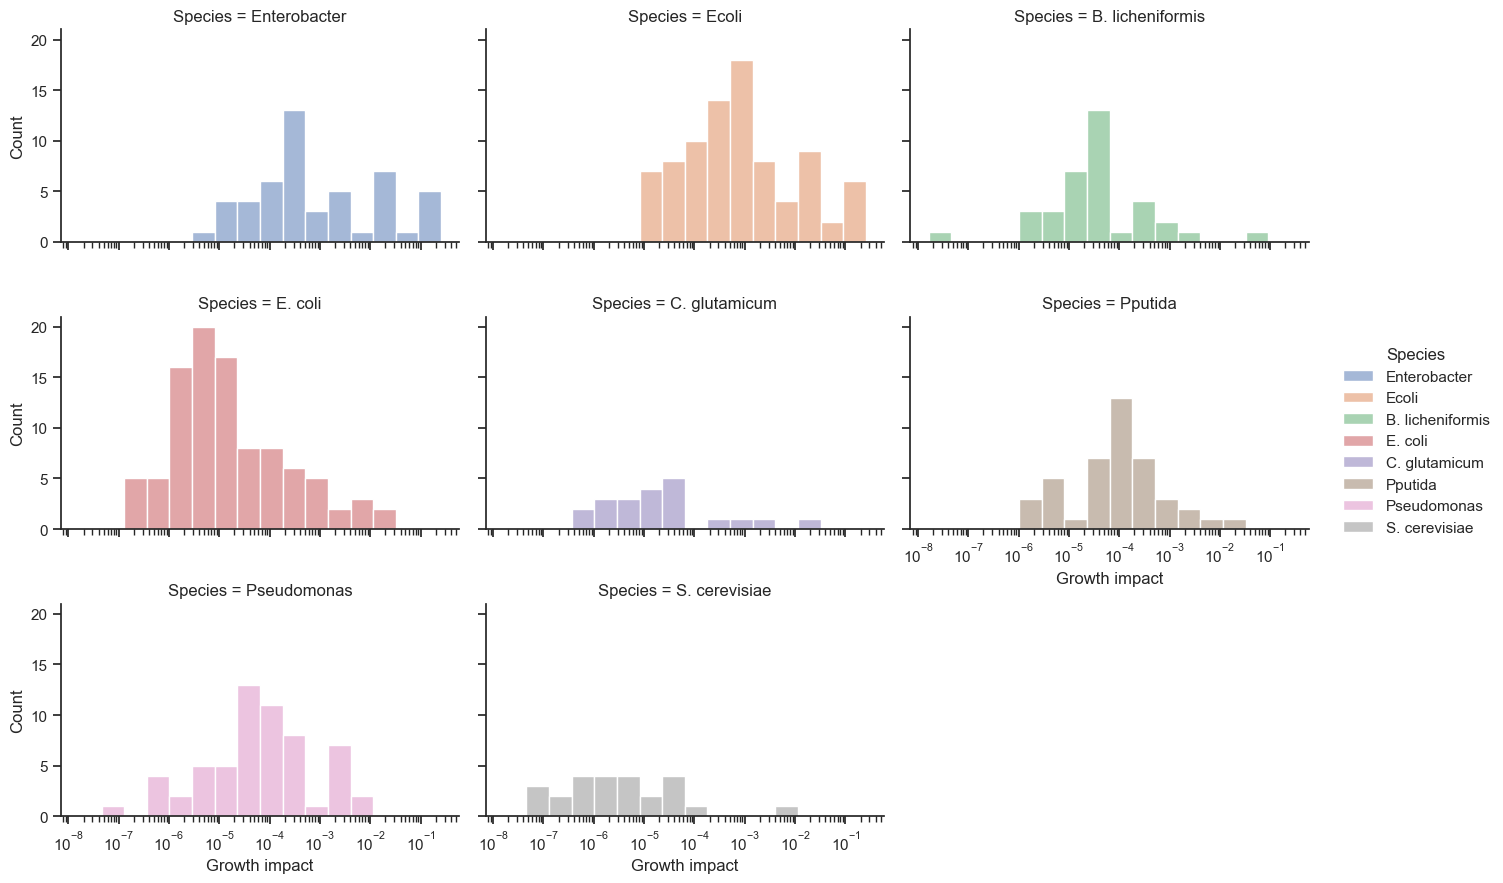

In [186]:
sns.displot(data = df, 
            x = 'Growth impact', col = 'Species', hue = 'Species', fill = True, common_norm = False, kind = 'hist',
            log_scale=True,col_wrap=3, height=3, aspect=1.5,)

In [187]:
df.sort_values(['Species', 'Metabolite'])

,Metabolite,Carbon source,Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],Metabolite value [gDW/mmol],N carbons,Mol weight [g/mol],Turnover [mmol/gDW/h],Species,Dataset,...,Metabolite value [gDW/g],log10(Rate [mmol C/gDW/h]),log10(Rate [g/gDW/h]),log10(Metabolite value [gDW/mmol C]),log10(Metabolite value [gDW/g]),log10(Turnover [mmol/gDW/h]),Species - Carbon source,Intracellular concentration [M],Growth impact,log10(Intracell. conc. [mM])
17,2-phosphoglycerate,Glucose,0.000923,0.000085,0.034358,3.0,184.041361,4.417085,B. licheniformis,Paczia-13,...,0.186687,-2.557826,-3.770032,-1.941092,-0.728886,0.645136,B. licheniformis - Glucose,NaN,3.170164e-05,NaN
35,3-phosphoglycerate,Glucose,0.000923,0.000085,0.034358,3.0,184.041361,6.276566,B. licheniformis,Paczia-13,...,0.186687,-2.557826,-3.770032,-1.941092,-0.728886,0.797722,B. licheniformis - Glucose,NaN,3.170164e-05,NaN
46,Acetate,Glucose,2.003534,0.145760,0.022533,2.0,59.044020,2.981847,B. licheniformis,Paczia-13,...,0.381637,0.602827,-0.927027,-1.948204,-0.418350,0.474485,B. licheniformis - Glucose,NaN,4.514637e-02,NaN
113,Alanine,Glucose,0.024987,0.007017,0.035225,3.0,89.093180,2.109228,B. licheniformis,Paczia-13,...,0.395373,-1.125161,-2.652438,-1.930270,-0.402993,0.324124,B. licheniformis - Glucose,NaN,8.801754e-04,NaN
132,Alpha-ketoglutarate,Glucose,0.010329,0.001549,0.051846,5.0,144.082260,4.614825,B. licheniformis,Paczia-13,...,0.359834,-1.286966,-2.827325,-1.984258,-0.443898,0.664155,B. licheniformis - Glucose,NaN,5.355208e-04,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,Serine,Glucose,0.000061,0.000022,0.023021,3.0,105.092580,0.288181,S. cerevisiae,Paczia-13,...,0.219050,-3.736135,-5.191684,-2.115005,-0.659456,-0.540334,S. cerevisiae - Glucose,NaN,1.408834e-06,NaN
707,Succinate,Glucose,0.002550,0.000381,0.005230,4.0,116.072160,0.063510,S. cerevisiae,Paczia-13,...,0.045060,-1.991416,-3.528748,-2.883536,-1.346204,-1.197156,S. cerevisiae - Glucose,NaN,1.333668e-05,NaN
764,Tyrosine,Glucose,0.000006,0.000003,0.074274,9.0,181.188540,0.045233,S. cerevisiae,Paczia-13,...,0.409927,-4.280281,-5.976392,-2.083405,-0.387293,-1.344541,S. cerevisiae - Glucose,NaN,4.328270e-07,NaN
770,Uracil,Glucose,0.000456,0.001154,0.161073,4.0,112.086760,0.000000,S. cerevisiae,Paczia-13,...,1.437036,-2.738800,-4.291306,-1.395038,0.157468,-inf,S. cerevisiae - Glucose,NaN,7.347876e-05,NaN


In [188]:
df.loc[df.Species=='E. coli',:].sort_values(['log10(Rate [mmol/gDW/h])', 'Metabolite'], ascending=False).head(30)

,Metabolite,Carbon source,Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],Metabolite value [gDW/mmol],N carbons,Mol weight [g/mol],Turnover [mmol/gDW/h],Species,Dataset,...,Metabolite value [gDW/g],log10(Rate [mmol C/gDW/h]),log10(Rate [g/gDW/h]),log10(Metabolite value [gDW/mmol C]),log10(Metabolite value [gDW/g]),log10(Turnover [mmol/gDW/h]),Species - Carbon source,Intracellular concentration [M],Growth impact,log10(Intracell. conc. [mM])
44,Acetate,L-alanine,2.114485,0.473112,0.013466,2.0,59.044020,0.174896,E. coli,SINTEF-23,...,0.228069,0.626235,-0.903619,-2.171787,-0.641933,-0.757221,E. coli - L-alanine,0.000658,0.028474,-0.181774
45,Acetate,Glucose,1.544754,0.188019,0.009873,2.0,59.044020,0.364498,E. coli,Paczia-13,...,0.167221,0.489889,-1.039965,-2.306563,-0.776709,-0.438305,E. coli - Glucose,0.000658,0.015252,-0.181774
43,Acetate,L-malate,0.614063,0.266627,0.001564,2.0,59.044020,0.320435,E. coli,SINTEF-23,...,0.026481,0.089243,-1.440611,-3.106914,-1.577060,-0.494260,E. coli - L-malate,0.000658,0.000960,-0.181774
644,Pyruvate,Glucose,0.584596,0.028017,0.017532,3.0,87.054120,9.205248,E. coli,Paczia-13,...,0.201397,0.243977,-1.293355,-2.233279,-0.695947,0.964035,E. coli - Glucose,0.008050,0.010249,0.905796
301,Formate,Galactose,0.357255,0.160892,0.006631,1.0,45.017440,0.181745,E. coli,SINTEF-23,...,0.147291,-0.447022,-1.793641,-2.178443,-0.831824,-0.740537,E. coli - Galactose,0.000184,0.002369,-0.735182
42,Acetate,Galactose,0.203725,0.106771,0.021537,2.0,59.044020,0.236215,E. coli,SINTEF-23,...,0.364764,-0.389927,-1.919781,-1.967842,-0.437988,-0.626693,E. coli - Galactose,0.000658,0.004388,-0.181774
127,Alpha-aminobutyrate,L-alanine,0.187598,0.020450,NaN,NaN,NaN,NaN,E. coli,SINTEF-23,...,NaN,NaN,NaN,NaN,NaN,NaN,E. coli - L-alanine,NaN,NaN,NaN
567,Orotate,Glucose,0.117487,0.008019,0.034516,5.0,155.088320,0.206967,E. coli,Paczia-13,...,0.222556,-0.231039,-1.739430,-2.160951,-0.652560,-0.684098,E. coli - Glucose,NaN,0.004055,NaN
603,Propionate,L-alanine,0.114260,0.014837,0.037693,3.0,73.070600,0.000000,E. coli,SINTEF-23,...,0.515843,-0.464986,-2.078364,-1.900861,-0.287483,-inf,E. coli - L-alanine,NaN,0.004307,NaN
602,Propionate,L-malate,0.081971,0.013858,0.009030,3.0,73.070600,0.000000,E. coli,SINTEF-23,...,0.123584,-0.609219,-2.222597,-2.521416,-0.908037,-inf,E. coli - L-malate,NaN,0.000740,NaN


In [189]:
df['log10(Intracell. conc. [mM])']=np.log10(df['Intracellular concentration [M]']*1e3)

In [190]:
df_no_cg = df.loc[df.Species!='C. glutamicum', :]
df_no_cg_no_nad = df_no_cg.loc[df_no_cg.Metabolite !='NAD', :]

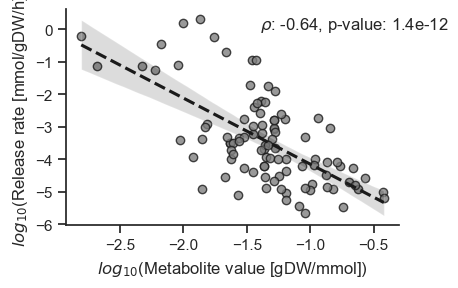

In [191]:
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel(r'$log_{10}$(Metabolite value [gDW/mmol])')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['log10(Metabolite value [gDW/mmol])', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['log10(Metabolite value [gDW/mmol])'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(-1.4, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('value_vs_release.pdf')
plt.savefig('value_vs_release.png', dpi = 400, bbox_inches="tight")
plt.show()

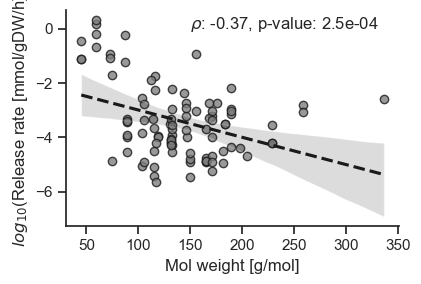

In [192]:
sns.set(font_scale = 1, style = 'ticks')
df_mean = df_no_cg_no_nad.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'Mol weight [g/mol]', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel('Mol weight [g/mol]')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['Mol weight [g/mol]', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['Mol weight [g/mol]'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(150, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('mw_vs_release_no_nad.pdf')
plt.savefig('mw_vs_release_no_nad.png', dpi = 400, bbox_inches="tight")

plt.show()

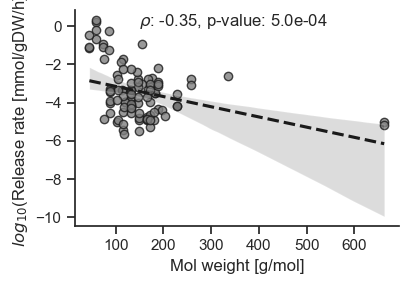

In [193]:
sns.set(font_scale = 1, style = 'ticks')
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'Mol weight [g/mol]', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel('Mol weight [g/mol]')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['Mol weight [g/mol]', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['Mol weight [g/mol]'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(150, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('mw_vs_release.pdf')
plt.savefig('mw_vs_release.png', dpi = 400, bbox_inches="tight")

plt.show()

In [194]:
df_mean.columns

Index(['Carbon source', 'Species', 'Metabolite', 'Rate [mmol/gDW/h]',
       'Std. Err [mmol/gDW/h]', 'Metabolite value [gDW/mmol]', 'N carbons',
       'Mol weight [g/mol]', 'Turnover [mmol/gDW/h]', 'Charge', 'Phosphate',
       'Hydrogen Bond Donor Count', 'Hydrogen Bond Acceptor Count',
       'Rotatable Bond Count', 'Topological Polar Surface Area',
       'Charge (pubchem)', 'xlogP', 'pubchem id', 'Molecular weight [g/mol]',
       'Intracellular concentration [uM]', 'log10(Rate [mmol/gDW/h])',
       'log10(Metabolite value [gDW/mmol])', 'Rate [mmol C/gDW/h]',
       'Rate [g/gDW/h]', 'Metabolite value [gDW/mmol C]',
       'Metabolite value [gDW/g]', 'log10(Rate [mmol C/gDW/h])',
       'log10(Rate [g/gDW/h])', 'log10(Metabolite value [gDW/mmol C])',
       'log10(Metabolite value [gDW/g])', 'log10(Turnover [mmol/gDW/h])',
       'Intracellular concentration [M]', 'Growth impact',
       'log10(Intracell. conc. [mM])'],
      dtype='object')

In [195]:
sns.set(font_scale = 1, style = 'ticks')
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'log P', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel('log P (solubility in oil/water)')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['log P', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['log P'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(-6, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('logP_vs_release.pdf')
plt.savefig('logP_vs_release.png', dpi = 400, bbox_inches="tight")

plt.show()

KeyError: "['log P'] not in index"

In [ ]:
sns.set(font_scale = 1, style = 'ticks')
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'log10(Intracell. conc. [mM])', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel(r'$log_{10}$(Intracell. conc. [mM])')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['log10(Intracell. conc. [mM])', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['log10(Intracell. conc. [mM])'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(-1.4, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('conc_vs_release.pdf')
plt.savefig('conc_vs_release.png', dpi = 400, bbox_inches="tight")

plt.show()

In [ ]:
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
df_mean.replace([-np.inf, np.inf], np.nan, inplace=True)
notnan_idx = ~df_mean[['log10(Turnover [mmol/gDW/h])', 'log10(Rate [mmol/gDW/h])']].isna().any(axis=1)
s_idx = df_mean.Species=='E. coli'
sns.lmplot(data = df_mean.loc[notnan_idx&s_idx,:], x = 'log10(Turnover [mmol/gDW/h])', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel(r'$log_{10}$(Turnover [mmol/gDW/h])')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['log10(Turnover [mmol/gDW/h])', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['log10(Turnover [mmol/gDW/h])'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(-4, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
plt.savefig('turnover_vs_release.pdf')
plt.savefig('turnover_vs_release.png', dpi = 400, bbox_inches="tight")

plt.show()

In [ ]:
sns.set(font_scale = 1.5, style = 'ticks')
p = sns.relplot(data = df_no_cg, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, hue = 'Compound class', s = 100, facet_kws={'sharex': False, 'sharey': False})
p.map(sns.regplot, 'log10(Metabolite value [gDW/mmol])', 'log10(Rate [mmol/gDW/h])', scatter = False, color = 'gray')
p.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(
    p, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title='Metabolite class', frameon=True,
)
for lh in p.legend.legend_handles: 
    lh._sizes = [250] 
plt.tight_layout()
# sns.regplot(data = df, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, scatter=False, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('value_vs_rate.png', dpi = 400, bbox_inches="tight")
plt.savefig('value_vs_rate.pdf', bbox_inches="tight")
plt.show()

In [ ]:
sns.set(font_scale = 1.5, style = 'ticks')
p = sns.relplot(data = df, x = 'log10(Metabolite value [gDW/mmol C])', y = 'log10(Rate [mmol C/gDW/h])', col = 'Species - Carbon source', col_wrap=3, hue = 'Compound class', s = 100, facet_kws={'sharex': False, 'sharey': False})
p.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.show()

In [ ]:
p = sns.relplot(data = df_no_cg, x = 'log10(Metabolite value [gDW/g])', y = 'log10(Rate [g/gDW/h])', col = 'Species - Carbon source', col_wrap=3, hue = 'Compound class', s = 100, facet_kws={'sharex': False, 'sharey': False})
p.map(sns.regplot, 'log10(Metabolite value [gDW/g])', 'log10(Rate [g/gDW/h])', scatter = False, color = 'gray')
p.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(
    p, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title='Metabolite class', frameon=True,
)
for lh in p.legend.legend_handles: 
    lh._sizes = [250] 
plt.tight_layout()
# sns.regplot(data = df, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, scatter=False, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('value_vs_rate_g.png', dpi = 400, bbox_inches="tight")
plt.savefig('value_vs_rate_g.pdf', bbox_inches="tight")
plt.show()

In [ ]:
sns.boxplot(data = df.loc[df.Species=='E. coli'], y = 'Compound class', x = 'log10(Rate [g/gDW/h])', order=['Carboxylic acid', 'Phosphorylated sugar', 'Amino acid', 'Nucleosides and nucleotides', 'Other'])
sns.despine()
plt.tight_layout()
plt.savefig('boxplot_rates.png', dpi = 400)
plt.show()

In [ ]:
sns.boxplot(data = df.loc[df.Species=='E. coli'], y = 'Compound class', x = 'log10(Metabolite value [gDW/mmol])', order=['Carboxylic acid', 'Phosphorylated sugar', 'Amino acid', 'Nucleosides and nucleotides', 'Other'])
sns.despine()
plt.tight_layout()
plt.savefig('boxplot_values.png', dpi = 400)
plt.show()

In [ ]:
sns.lmplot(data = df, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})

In [ ]:
sns.lmplot(data = df, x = 'log10(Metabolite value [gDW/mmol C])', y = 'log10(Rate [mmol C/gDW/h])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})

In [ ]:
sns.lmplot(data = df, x = 'log10(Metabolite value [gDW/g])', y = 'log10(Rate [g/gDW/h])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})
plt.show()

In [ ]:
'Metabolite', 'Carbon source',
xvarsL = ['Mol weight [g/mol]', 'Topological Polar Surface Area', 'log10(Intracell. conc. [mM])', 'log P', 'log10(Rate [mmol/gDW/h])','Charge','Phosphate',
       'log10(Metabolite value [gDW/mmol])','log10(Turnover [mmol/gDW/h])']
xvarsS = ['Mol weight [g/mol]', 'Topological Polar Surface Area', 'log10(Intracell. conc. [mM])', 'log P',
       'log10(Metabolite value [gDW/mmol])', 'log10(Rate [mmol/gDW/h])']

In [ ]:
sns.pairplot(df_no_cg, x_vars=xvarsL, y_vars=xvarsL, hue = 'Species - Carbon source')
plt.show()

In [ ]:
sns.pairplot(df_no_cg, x_vars=xvarsS, y_vars=xvarsS, hue = 'Species - Carbon source')
plt.show()

In [ ]:
sns.pairplot(df_no_cg_no_nad, x_vars=xvarsS, y_vars=xvarsS, hue = 'Species - Carbon source')

In [ ]:
sns.pairplot(df_no_cg, x_vars=xvarsS, y_vars=xvarsS, 
            kind="reg")

In [ ]:
sns.pairplot(df_no_cg_no_nad, x_vars=xvarsS, y_vars=xvarsS, 
            kind="reg")

In [ ]:
sns.set(font_scale = 0.8,style = 'ticks')
sns.pairplot(df_no_cg_no_nad, x_vars=xvarsS[-3:-1], 
            kind="reg", y_vars = ['log10(Rate [mmol/gDW/h])'], palette='tab20', 
             plot_kws={'scatter_kws':{'s':10}, 'color': '#1f77b4'})
plt.savefig('other_factors2.png', dpi = 400)
plt.show()

In [ ]:
sns.lmplot(data = df_no_cg_no_nad, x = 'Mol weight [g/mol]', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})
plt.show()

In [ ]:
# sns.lmplot(data=df_no_cg, y = 'log10(Intracellular concentration [mM])', x = 'log10(Metabolite value [gDW/mmol])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})
# plt.show()

# Rate distribution

In [ ]:
from scipy import stats as st

In [ ]:
fit = st.fit(st.norm, [x for x in df_no_cg['log10(Rate [mmol/gDW/h])'] if np.isfinite(x)],
             bounds = [[-5, -2], [0, 3]])
print(fit.params)

In [ ]:
fit.plot()
plt.show()

In [ ]:
df_no_cg[['Metabolite', 'Carbon source', 'Species', 'log10(Rate [mmol/gDW/h])','Rate [mmol/gDW/h]']].to_csv('D_rates_and_meta.csv')

In [ ]:
df_no_cg['log10(Rate [mmol/gDW/h])'].to_csv('log10_rates.csv')
df_no_cg['Rate [mmol/gDW/h]'].to_csv('D_rates.csv')

In [ ]:
x = np.linspace(-8, 1, 100)
dist = fit.pxf(x, loc = fit.params[0], scale = fit.params[1])

In [ ]:
sns.set_style('white')
ax = sns.histplot(df_no_cg['log10(Rate [mmol/gDW/h])'], stat='density', palette='tab10', color='C2', bins = 20)
sns.lineplot(x = x, y = dist, ax = ax, color = 'k', ls = '--', label = 'lognormal distribution')
sns.move_legend(ax, loc = 1)
sns.despine()
plt.show()

In [ ]:
# fit.plot(df_no_cg['log10(Rate [mmol/gDW/h])'])
# plt.show()

In [ ]:
sns.histplot(df_no_cg['log10(Rate [mmol/gDW/h])'], color='C0')
plt.show()

# Linear model

In [ ]:
import statsmodels.formula.api as sm

In [ ]:
# idx = df_no_cg.Species == 'B. licheniformis'

In [ ]:
df_ecoli = df.loc[df.Species == 'E. coli']

In [ ]:
# np.isnan(df_no_cg[key]).sum()

In [ ]:
xvarsL = ['Mol weight [g/mol]', 'Topological Polar Surface Area', 'log10(Intracell. conc. [mM])', 'log P', 'log10(Rate [mmol/gDW/h])','Charge','Phosphate',
       'log10(Metabolite value [gDW/mmol])','log10(Turnover [mmol/gDW/h])', 'Compound class']

In [ ]:
var_explained = {}
for key in xvarsL:
    print(key)
    if key == 'log10(Rate [mmol/gDW/h])':
        continue
    lindf = pd.DataFrame()
    lindf['Y'] = df_ecoli['log10(Rate [mmol/gDW/h])']
    lindf['A'] = df_ecoli[key]
    print(lindf['A'])
    lindf.replace([np.inf, -np.inf], np.nan, inplace=True)
    lindf.dropna(inplace=True)
    # print(np.isnan(lindf['A']).sum())
    res = sm.ols(formula="Y ~ A", data=lindf).fit()
    res.summary()
    print(key, res.rsquared)
    var_explained[key] = res.rsquared_adj

In [ ]:
lindf = pd.DataFrame()
lindf['Y'] = df_ecoli['log10(Rate [mmol/gDW/h])']
lindf['A'] = df_ecoli['log10(Intracell. conc. [mM])']
lindf['B'] = df_ecoli['log10(Metabolite value [gDW/mmol])']
lindf['C'] = df_ecoli['Charge']
lindf['D'] = df_ecoli['Mol weight [g/mol]']
lindf['G'] = df_ecoli['Compound class']
lindf['E'] = df_ecoli['log P']
lindf['F'] = df_ecoli['log10(Turnover [mmol/gDW/h])']
lindf.replace([np.inf, -np.inf], np.nan, inplace=True)
lindf.dropna(inplace=True)
# lindf['F'] = df_no_cg['Mol weight [g/mol]']
# lindf['G'] = df_no_cg['Topological Polar Surface Area']
res = sm.ols(formula="Y ~ A + B + C + G", data=lindf).fit()
print(res.summary())
var_explained['Met. value + Int. conc + charge + compound class'] = res.rsquared_adj
print(var_explained)

In [ ]:
s = res.summary2()
print(s)
s.tables[1].to_csv('linear_model.csv')

In [ ]:
np.sqrt(res.mse_resid)

In [ ]:
np.std(res.resid)

In [ ]:
res.resid

In [ ]:
plt.hist(res.resid, bins=30)
plt.show()

In [ ]:
order = [k for k, v in sorted(var_explained.items(), key=lambda item: item[1])]

In [ ]:
sns.set(font_scale = 1, style = 'ticks')
keys = list(var_explained.keys())
# get values in the same order as keys, and parse percentage values
fig, ax = plt.subplots(1,1, figsize = (9, 4))
vals = list(var_explained.values())
sns.barplot(y=keys, x=vals, color = '#1f77b4', order = order, ax = ax)
plt.xlabel(r'adjusted $R^2$')
sns.despine()
plt.title('Variability of metabolite release rates explained - E. coli')
plt.tight_layout()
plt.savefig('barplot_ecoli.png', dpi = 400)

plt.show()

In [ ]:
sns.set(font_scale = 1, style = 'ticks')
keys = list(var_explained.keys())
# get values in the same order as keys, and parse percentage values
fig, ax = plt.subplots(1,1, figsize = (9, 4))
vals = list(var_explained.values())
sns.barplot(y=keys, x=vals, color = '#1f77b4', order = order, ax = ax)
plt.xlabel(r'adjusted $R^2$')
sns.despine()
plt.title('Variability of metabolite release rates explained - E. coli')
plt.tight_layout()
plt.savefig('barplot_ecoli.png', dpi = 400)

plt.show()

In [ ]:
xvarsL = ['Mol weight [g/mol]', 'Topological Polar Surface Area', 'log10(Intracell. conc. [mM])', 'log P', 'log10(Rate [mmol/gDW/h])','Charge','Phosphate',
       'log10(Metabolite value [gDW/mmol])','log10(Turnover [mmol/gDW/h])']